In [1]:
from datasetsforecast.m4 import M4

from statsmodels.tsa.stattools import acf, pacf

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import logging

from math import sqrt

In [2]:
sns.set_theme(style="whitegrid")
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
df_all, *_ = M4.load('./data', 'Hourly')
df_all['ds'] = df_all['ds'].astype(int)

# Just pick out the first few datasets to work with.
n_series = 20
uids = df_all['unique_id'].unique()[:n_series]
df = df_all.query('unique_id in @uids').copy()

df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


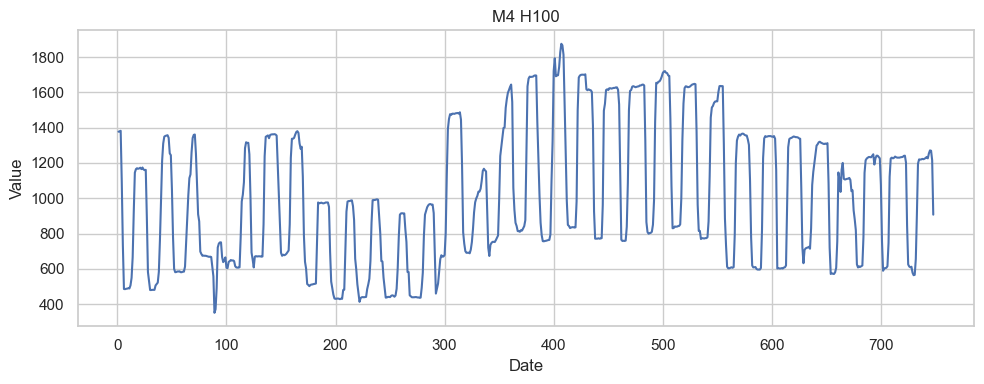

In [4]:
ds = df.query("unique_id == 'H100'").copy()

fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True)

sns.lineplot(ax=axs, data=ds, x='ds', y='y')
axs.set_title('M4 H100')
axs.set_ylabel('Value')

axs.set_xlabel('Date')

plt.tight_layout()
plt.show()

### Backshift
---
Define the **backshift notation** which brings you back by a single timestep.

$$By_t = y_{t-1}$$

A first-order difference is simply $y'_t = (1-B)y_t$. Same for the second-order $y''_t = (1-B)^2y_t$.

A seasonal difference is a single seasonal step.

$$y'_t = (1-B^m)y_t$$

We use this often in ARIMA models since we autoregress on the time series values and an error term.

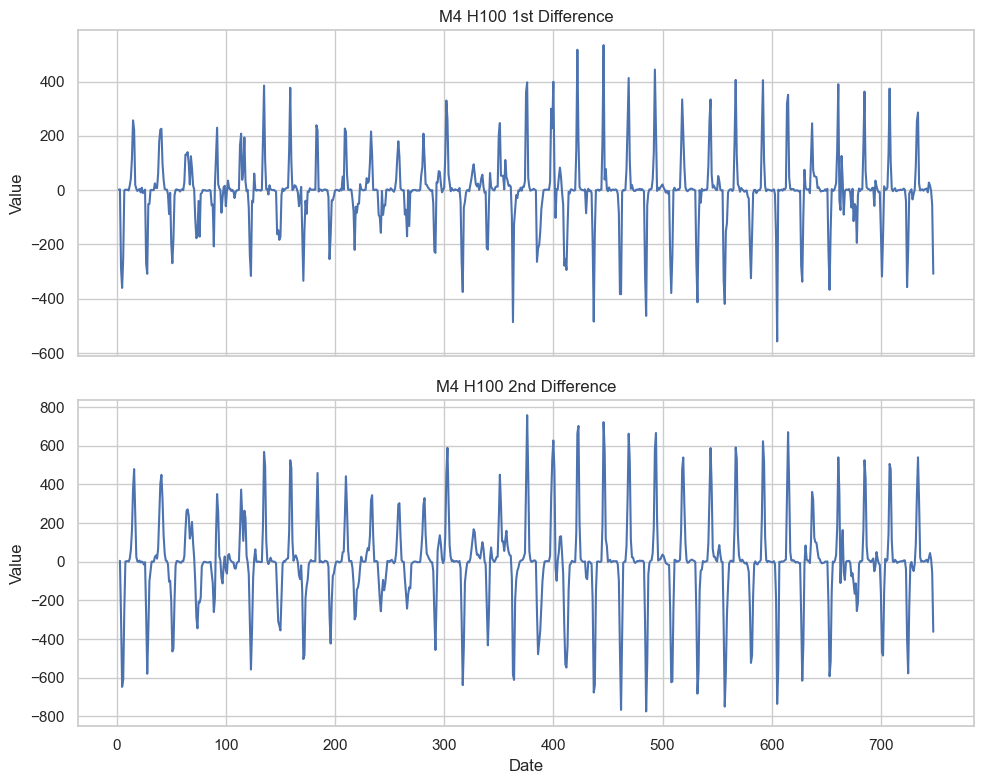

In [5]:
ds['y_diff_1'] = ds['y'].diff(periods=1)
ds['y_diff_2'] = ds['y'].diff(periods=2)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(ax=axs[0], data=ds, x='ds', y='y_diff_1')
axs[0].set_title('M4 H100 1st Difference')
axs[0].set_ylabel('Value')

sns.lineplot(ax=axs[1], data=ds, x='ds', y='y_diff_2')

axs[1].set_title('M4 H100 2nd Difference')
axs[1].set_ylabel('Value')

axs[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

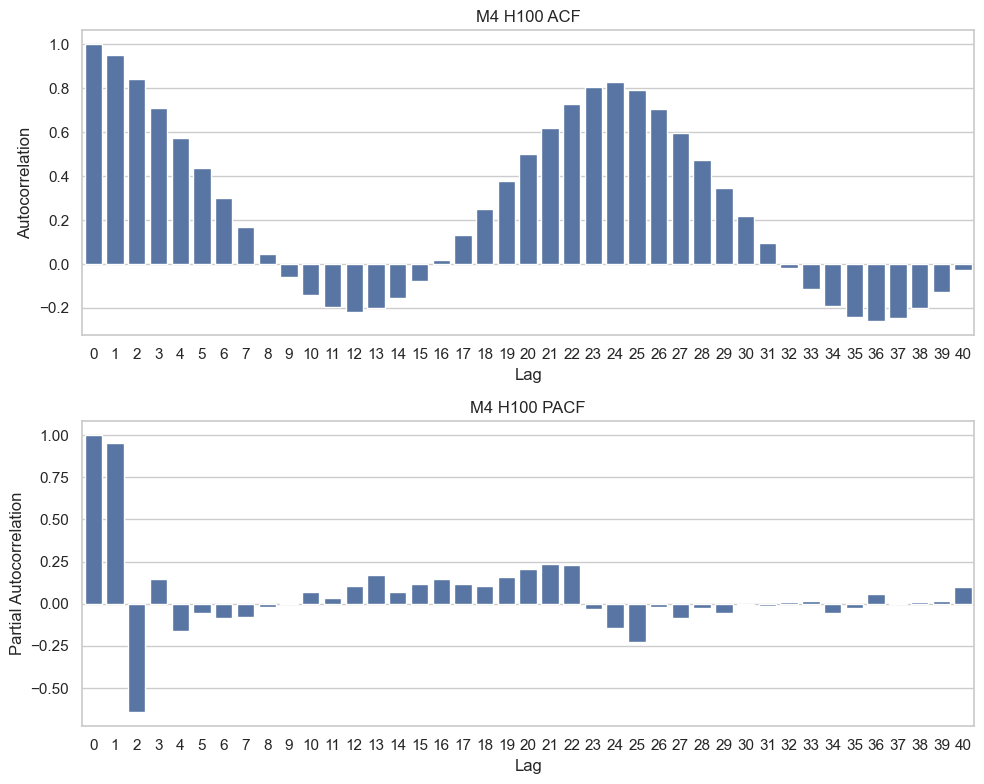

In [6]:
total_lags = 40

acf_values = acf(ds['y'], nlags=total_lags)
pacf_values = pacf(ds['y'], nlags=total_lags)

lags = np.arange(total_lags + 1)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

sns.barplot(ax=axs[0], x=lags, y=acf_values)
axs[0].set_title('M4 H100 ACF')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_xlabel('Lag')

sns.barplot(ax=axs[1], x=lags, y=pacf_values)
axs[1].set_title('M4 H100 PACF')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

### KPSS Test
---
Stands for *Kwiatkowsi-Phillips-Schimdt-Shin*, the economists who came up with the test. 

$$y_t = \xi t + \sum_{i=0}^tu_t + \epsilon_t$$

where
- $u_t$ is the random noise terms of distribution $(0, \sigma_u^2)$
- $\epsilon_t$ is the stationarity error
- $t$ is the timestep with scalar $\xi$

> I think it's best to detrend ($\xi=0$) before doing this test. Their model assumes trend to be of a scaled linearly with a single parameter.

Onto the parts of the hypothesis testing.

 - *Null hypothesis*: No random walk exists, $\sigma_u^2 = 0$.
 - *Test statistic*: 

$$LM = \frac{1}{{\hat{\sigma}_\epsilon^2}}\sum_{t=1}^T S_t^2$$

where $S_t$ is the rolling sum of the residuals.

$$S_t = \sum_{i=1}^t e_i$$

And $\hat{\sigma}_e^2$ is the standard error of the regression errors.

- *p-value*: From $\chi^2(T)$ distribution.
 
> Also, to understand why this comes out to a $\chi^2$ test, the sum of normal distributions is normal; then when you square and sum them, you get a $\chi^2$ distribution.

In [9]:
p_test = kpss(ds['y'].diff(1).dropna())

print(p_test)

(0.008395182562719945, 0.1, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\Seraph\AppData\Local\Temp\ipykernel_9240\872484366.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_test = kpss(ds['y'].diff(1).dropna())


In [123]:
def ARIMA_helper(order, seasonal_order = None, h=0): 
    if seasonal_order is None:
        ar = ARIMA(ds['y'].reset_index(drop=True), order=order)
    else:
        ar = ARIMA(ds['y'].reset_index(drop=True), order=order, seasonal_order=seasonal_order)
        
    results = ar.fit()
    
    if h != 0:        
        forecasts = results.get_forecast(steps=h)
        means = forecasts.predicted_mean
        conf_ints = forecasts.conf_int()

    preds = results.predict()
    resids = results.resid
    
    if seasonal_order is not None:
        if seasonal_order[1] != 0:
            preds = preds[seasonal_order[3]+1:]
            resids = resids[seasonal_order[3]+1:]

    rmse = sqrt((resids**2).mean())
    mse = abs(resids).mean()
    
    n = len(ds['y'])
    k = results.df_model + 1
    
    
    if seasonal_order is not None:
        if seasonal_order[1] != 0:
            n -= seasonal_order[3]
    
    aic = results.aic
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("AICc: ", aicc)
    
    plt.figure(figsize=(10,4))
    plt.title(f'ARIMA{order}{seasonal_order} on M4 Data')

    sns.lineplot(x=ds['ds'], y=ds['y'])
    sns.lineplot(x=preds.index, y=preds)
    
    if h != 0:
        sns.lineplot(x=means.index, y=means, color='red')
        plt.fill_between(x=conf_ints.index, y1=conf_ints['lower y'], y2=conf_ints['upper y'], color='red', alpha=0.3)
    
    plt.show()

### AR
---
We can make a model that depends on only the previous terms of an indexed time series; this is called an **Autoregressive model** AR($p$). On top of this, add a single white noise term $e_t$.

> 'auto' means self, therefore autoregressive meaning regressing on yourself (own values). 

$$y_t = c + \phi_1y_{t-1} + \phi_2 y_{y-2} + \cdots + \phi_p y_{t-p} + e_t$$

We can write it with a summand.

$$y_t = \sum_{i=1}^p \phi_i y_{t-i} + c +  e_t$$

And in backshift notation.

$$(1- \phi_1 B - \cdots - \phi_p B^p) y_t = c + e_t$$

#### Stationarity
Now we want to estimate the parameters of this model. We need to ensure stationarity on the AR model so that the autoregressive nature converges to a well-defined answer. 

> It's evident that a pure Linear Algebra approach won't work since your system will always be under-constrained.

First, let's find a way to rewrite the model to better study it. Notice you can write an AR($p$) model as a MA($\infty$) model. Starting with an AR($1$), expand on the autoregressive term $y_{t-1}$.

$$\begin{align}
y_t &= \phi_1 \textcolor{RedOrange}{y_{y-1}} + e_t \\
&= \phi_1 (\textcolor{RedOrange}{\phi_1 y_{t-2} + e_{t-1}}) + e_t \\
&= \phi^2y_{t-2} + \phi_1 e_{t-1} + e_t \\
&= \phi_1^3 y_{t-3} + \phi_1^2 e_{t-2} + \phi_1 e_{t-1} + e_t \\
&= \cdots \\
&= e_t + \sum_{i=1}^\infty \phi_1^i e_{t-i} \\
\end{align}$$

We want this series to converge. The only way that happens is when the parameter $\phi_1^i$ dies off eventually. What we want is for the limit of the sequence $\{\phi_1^i\}$ to converge to $0$. 

$$\lim_{i \rightarrow \infty} \phi_1^i = 0$$

That only happens when the sequence is a geometric series, therefore $\phi_1$ must lie in $(-1,1)$. For higher order AR models, the limiting behavior is the same, but the analysis becomes complicated.

#### ACF and PACF
The partial autocorrelation coefficients are estimates of the parameters in an AR($k$). The $k$th partial autocorrelation $\alpha_k$ is an estimate for the AR coefficient $\phi_k$ in an AR($k$) model.

> When I was messing around with an AR($1$) model with the averages, I get $\phi^k = 1/\alpha^k$.

An AR model can be identified If 
- the ACF plot is exponentially decaying or sinusoidal
- there is a large spike at lag $p$ in PACF, but none beyond lag $p$

RMSE:  90.87072499923384
MSE:  60.83549328407814
AICc:  8872.472913067377


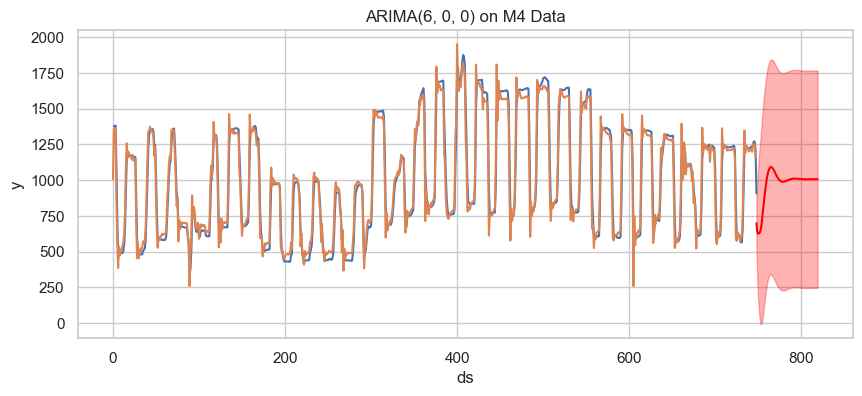

In [120]:
ARIMA_helper((6,0,0), h=72)

### SARIMA
---
We can add a seasonality term $(1-B^m)$ of length $m$ which accounts for the seasonal parts. We specify the non-seasonal and seasonal part ARIMA($p$,$d$,$q$)($P$,$D$,$Q$)$_m$. What we do is pre-append every component of an ARIMA model with a seasonal difference. For brevity, we will formulate an ARIMA(1,1,1)(2,1,1)$_4$ model.

$$(1- \phi_1 B) (1-\Phi_1B^4-\Phi B^8)(1-B) (1-B^4) y_t = c + (1 + \theta_1 B)(1+\Theta_1B^4)e_t$$

#### SAR

Your time series may follow a SAR(1,0,0)$_s$ model if 

- an exponential decay in the season lags of the ACF ($s, 2s, 3s, \ldots$)
- a spike at lag $s$ exists in the PACF but no where else

RMSE:  83.02276579160389
MSE:  54.621669593760835
AICc:  8735.98718421388


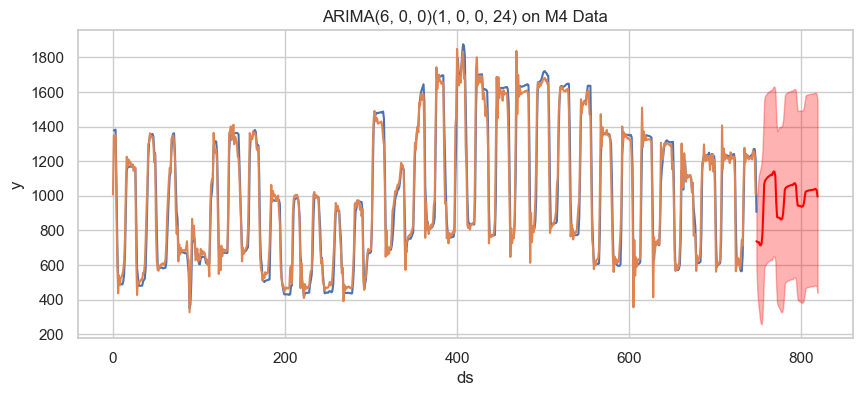

In [124]:
ARIMA_helper((6,0,0), (1,0,0,24), h=72)

RMSE:  85.9052483279681
MSE:  54.54880833168629
AICc:  8522.354717874538


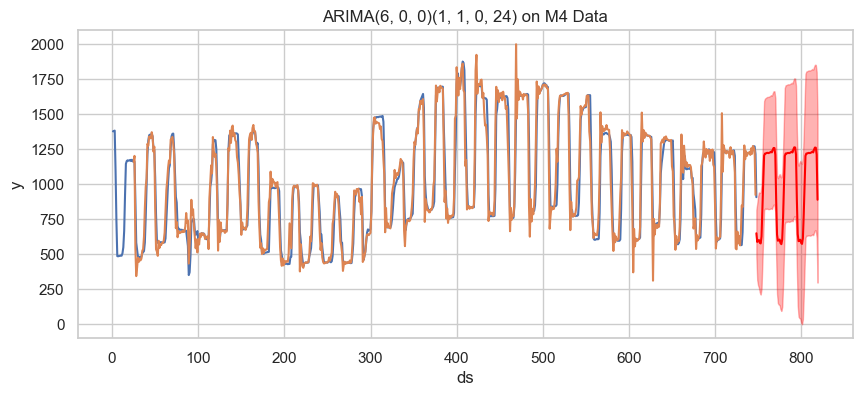

In [125]:
ARIMA_helper((6,0,0), (1,1,0,24), h=72)